In [1]:
%matplotlib inline

In [133]:
import os
import sys
import numpy as np
import pandas as pd
import itertools as it
import matplotlib.pyplot as plt
import seaborn as sns
from maskfunctions import *
from scipy.stats import lognorm
from scipy.stats import skewnorm
from scipy.stats import gamma
import statsmodels

In [3]:
# Location and names of data files
data_dir = "/Users/jeremysmith/Documents/BTS_Airline_Data/"
file_pre = "On_Time_On_Time_Performance_2016"
path_airports = os.path.join(data_dir, "airports.dat")
path_emplanes = os.path.join(data_dir, "cy15-commercial-service-enplanements.csv")

In [4]:
# Delay Data
data_list = []
for month in range(12):
    file_month = "{:s}_{:02d}".format(file_pre, month + 1)
    path_month = os.path.join(data_dir, file_month, file_month + ".csv")
    data_list.append(pd.read_csv(path_month,
                                usecols=[2,3,4,5,8,10,14,23,31,33,36,39,42,44,47,52,54,56,57,58,59,60]))
data_delays = pd.concat(data_list, ignore_index=True)

In [5]:
data_delays.head()

,Month,DayofMonth,DayOfWeek,FlightDate,Carrier,FlightNum,Origin,Dest,DepDelay,DepDel15,...,ArrDelay,ArrDel15,Cancelled,AirTime,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,1,6,3,2016-01-06,AA,43,DFW,DTW,-3.0,0.0,...,-6.0,0.0,0.0,132.0,986.0,NaN,NaN,NaN,NaN,NaN
1,1,7,4,2016-01-07,AA,43,DFW,DTW,-4.0,0.0,...,-12.0,0.0,0.0,126.0,986.0,NaN,NaN,NaN,NaN,NaN
2,1,8,5,2016-01-08,AA,43,DFW,DTW,-5.0,0.0,...,7.0,0.0,0.0,135.0,986.0,NaN,NaN,NaN,NaN,NaN
3,1,9,6,2016-01-09,AA,43,DFW,DTW,2.0,0.0,...,-5.0,0.0,0.0,129.0,986.0,NaN,NaN,NaN,NaN,NaN
4,1,10,7,2016-01-10,AA,43,DFW,DTW,100.0,1.0,...,113.0,1.0,0.0,137.0,986.0,0.0,0.0,47.0,0.0,66.0


In [6]:
# Airport Location Data
head_airports = ['Name', 'City', 'Country', 'IATA',
                 'Latitude', 'Longitude', 'Altitude',
                 'Timezone']
data_airports = pd.read_csv(path_airports,
                           usecols=[1,2,3,4,6,7,8,9],
                           names=head_airports)

In [7]:
# Airport USA Enplanements Data
data_emplanes = pd.read_csv(path_emplanes,
                           usecols=[2,3,6,7,8],
                           thousands=',')
data_emplanes.rename(columns={'Locid':'IATA', 'CY 15 Enplanements':'CY15enplane'}, inplace=True)

In [8]:
# Merge Airport Data
data_airports_merged = pd.merge(data_emplanes, data_airports, on='IATA', how='left', copy=False)

In [9]:
data_airports_merged_us = data_airports_merged[data_airports_merged.Country == "United States"]
data_airports_merged_us = data_airports_merged_us[data_airports_merged_us.CY15enplane > 100000]
data_airports_merged_us.head()

,ST,IATA,S/L,Hub,CY15enplane,Name,City,Country,Latitude,Longitude,Altitude,Timezone
0,GA,ATL,P,L,49340732,Hartsfield Jackson Atlanta International Airport,Atlanta,United States,33.636700,-84.428101,1026.0,-5
1,CA,LAX,P,L,36351272,Los Angeles International Airport,Los Angeles,United States,33.942501,-118.407997,125.0,-8
2,IL,ORD,P,L,36305668,Chicago O'Hare International Airport,Chicago,United States,41.978600,-87.904800,672.0,-6
3,TX,DFW,P,L,31589839,Dallas Fort Worth International Airport,Dallas-Fort Worth,United States,32.896801,-97.038002,607.0,-6
4,NY,JFK,P,L,27782369,John F Kennedy International Airport,New York,United States,40.639801,-73.778900,13.0,-5


In [10]:
# Output Airport Data Without Delay Data Embedded
data_airports_merged_us.to_csv("visualization/airports.csv")

In [280]:
# Create Filter and Mask
airports = data_airports_merged_us['IATA'].values
carrier = 'ALL'                                     # 2 letter carrier code or ALL
month = 0                                           # month (1 - 12, 0 = all)
dotw = 0                                            # day of the week (1 - 7, 0 = all)
mask, matches = create_mask(data_delays, airports, carrier, month, dotw)
print "There are {:d} matching flights for this filter".format(matches)

There are 5508157 matching flights for this filter


In [281]:
# Information grouped by destination airport
groupDest = data_delays[mask].groupby('Dest', as_index=False)

num_arr = groupDest.size().to_frame().reset_index().rename(columns={0:'ArrNum'})
fraction_delayed = groupDest['ArrDel15'].mean()
med_in_time = groupDest['TaxiIn','ArrDelay'].median()
mergeDest = pd.merge(fraction_delayed, med_in_time, on="Dest").merge(num_arr, on="Dest")
mergeDest.ArrDel15 *= 100
mergeDest.rename(columns={'Dest':'IATA', 'ArrDel15':'PercentArrDel15'}, inplace=True)

In [282]:
# Information grouped by origin airport
groupOrig = data_delays[mask].groupby('Origin', as_index=False)

num_dep = groupOrig.size().to_frame().reset_index().rename(columns={0:'DepNum'})
fraction_cancel = groupOrig['Cancelled'].mean()
med_out_time = groupOrig['TaxiOut', 'DepDelay'].median()
mergeOrig = pd.merge(fraction_cancel, med_out_time, on="Origin").merge(num_dep, on="Origin")
mergeOrig.Cancelled *= 100
mergeOrig.rename(columns={'Origin':'IATA', 'Cancelled':'PercentCancelled'}, inplace=True)

In [283]:
# Merge Origin and Destination delay data
mergeAll = pd.merge(mergeDest, mergeOrig, on='IATA')

In [284]:
# Merge delay data into the airport information df
data_airports_merged_us_wdelay = pd.merge(data_airports_merged_us, mergeAll, on='IATA', how='inner', copy=False)

In [285]:
data_airports_merged_us_wdelay.head()

,ST,IATA,S/L,Hub,CY15enplane,Name,City,Country,Latitude,Longitude,Altitude,Timezone,PercentArrDel15,TaxiIn,ArrDelay,ArrNum,PercentCancelled,TaxiOut,DepDelay,DepNum
0,GA,ATL,P,L,49340732,Hartsfield Jackson Atlanta International Airport,Atlanta,United States,33.636700,-84.428101,1026.0,-5,13.021813,7.0,-10.0,374492,0.584325,15.0,-1.0,384375
1,CA,LAX,P,L,36351272,Los Angeles International Airport,Los Angeles,United States,33.942501,-118.407997,125.0,-8,23.284165,10.0,-2.0,212823,0.891620,16.0,0.0,212983
2,IL,ORD,P,L,36305668,Chicago O'Hare International Airport,Chicago,United States,41.978600,-87.904800,672.0,-6,18.809349,11.0,-7.0,237305,1.622406,17.0,-1.0,244082
3,TX,DFW,P,L,31589839,Dallas Fort Worth International Airport,Dallas-Fort Worth,United States,32.896801,-97.038002,607.0,-6,18.000621,10.0,-6.0,183403,1.167565,16.0,-2.0,196049
4,NY,JFK,P,L,27782369,John F Kennedy International Airport,New York,United States,40.639801,-73.778900,13.0,-5,22.293996,8.0,-6.0,91718,1.236816,22.0,-1.0,97751


In [286]:
# Output Airport Data With Delay Data Embedded
data_airports_merged_us_wdelay.to_csv("visualization/airports_wdelaydata_{:s}.csv".format(carrier))

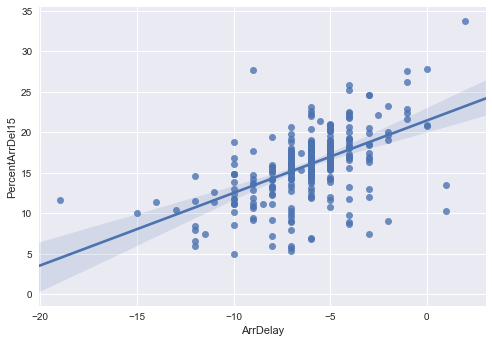

In [287]:
sns.regplot('ArrDelay', 'PercentArrDel15', data=mergeDest[mergeDest.ArrNum > 10])

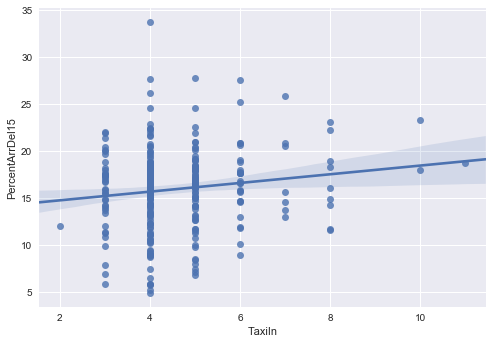

In [288]:
sns.regplot('TaxiIn', 'PercentArrDel15', data=mergeDest[mergeDest.ArrNum > 10])

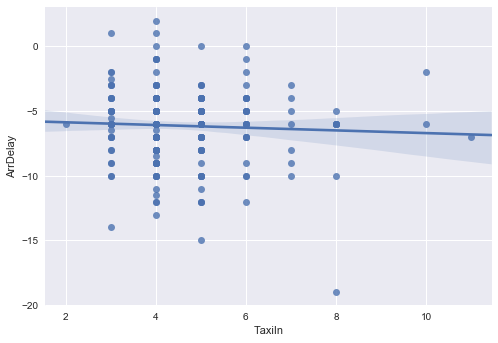

In [289]:
sns.regplot('TaxiIn', 'ArrDelay', data=mergeDest[mergeDest.ArrNum > 10])

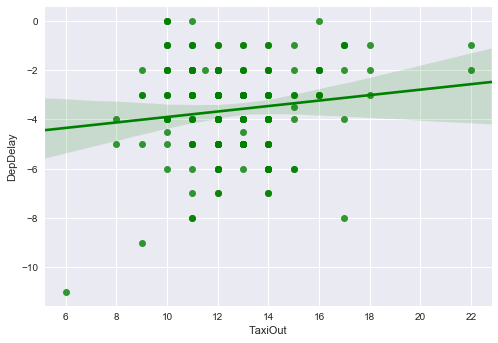

In [290]:
sns.regplot('TaxiOut', 'DepDelay', data=mergeOrig[mergeOrig.DepNum > 10], color='green')

0.309870741153 -60.2660458004 54.6370906624


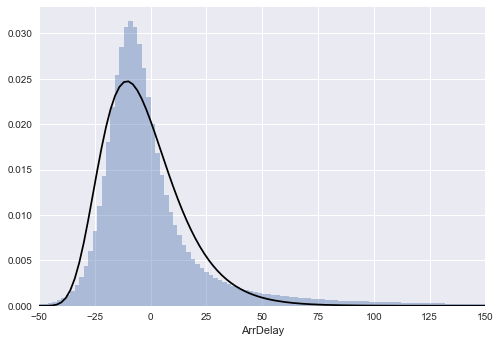

In [291]:
a = data_delays[mask]['ArrDelay'].dropna()
a_sampled = np.random.choice(a, size=2000, replace=False)
a_sampled = a_sampled[(a_sampled < 75) & (a_sampled > -50)]
shape, loc, scale = lognorm.fit(a_sampled, 0.1, loc=-50, scale=40)
x = np.linspace(-50,350,201)
d = lognorm.pdf(x, shape, loc, scale)
sns.distplot(a, bins=x, kde=False, norm_hist=True)
plt.plot(x, d, color='black')
sns.plt.xlim(-50,150)
print shape, loc, scale

0.551856103921 0.459453247585 5.60867223882


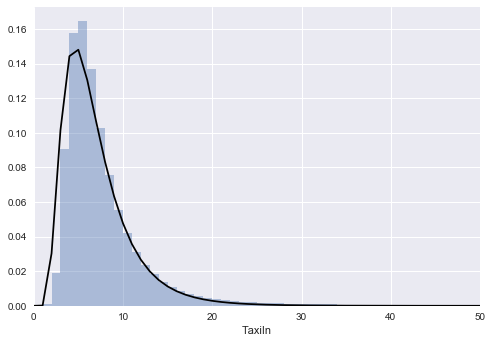

In [292]:
a = data_delays[mask]['TaxiIn'].dropna()
a_sampled = np.random.choice(a, size=1000, replace=False)
a_sampled = a_sampled[(a_sampled < 30) & (a_sampled > 0)]
shape, loc, scale = lognorm.fit(a_sampled, 0.5, loc=1, scale=5)
x = np.linspace(0,200,201)
d = lognorm.pdf(x, shape, loc, scale)
sns.distplot(a, bins=x, kde=False, norm_hist=True)
plt.plot(x, d, color='black')
sns.plt.xlim(0,50)
print shape, loc, scale

0.480215652055 -18.9182957863 17.9172697125


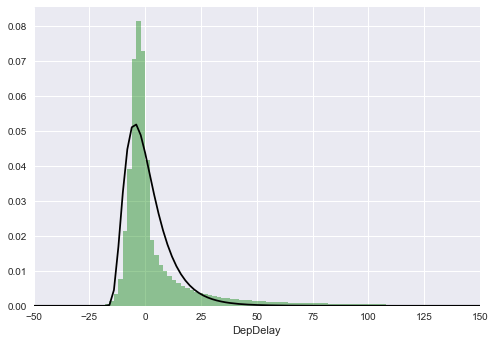

In [293]:
a = data_delays[mask]['DepDelay'].dropna()
a_sampled = np.random.choice(a, size=2000, replace=False)
a_sampled = a_sampled[(a_sampled < 50) & (a_sampled > -20)]
shape, loc, scale = lognorm.fit(a_sampled,1, loc=-20, scale=15)
x = np.linspace(-50,350,201)
d = lognorm.pdf(x, shape, loc, scale)
sns.distplot(a, bins=x, color='green', kde=False, norm_hist=True)
plt.plot(x, d, color='black')
sns.plt.xlim(-50,150)
print shape, loc, scale

0.493768721214 2.44336551902 11.9200569963


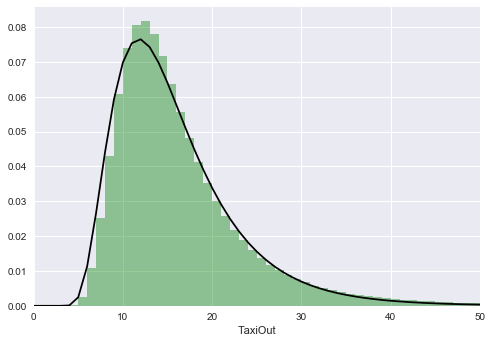

In [294]:
a = data_delays[mask]['TaxiOut'].dropna()
a_sampled = np.random.choice(a, size=1000, replace=False)
a_sampled = a_sampled[(a_sampled < 50) & (a_sampled > 0)]
shape, loc, scale = lognorm.fit(a_sampled, 0.5, loc=4, scale=10)
x = np.linspace(0,200,201)
d = lognorm.pdf(x, shape, loc, scale)
sns.distplot(a, bins=x, color='green', kde=False, norm_hist=True)
plt.plot(x, d, color='black')
sns.plt.xlim(0,50)
print shape, loc, scale